In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [2]:
def prepare_mnist_data(mnist):
    #flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    #convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    #create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    #cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    #shuffle, batch, prefetch
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(32)
    mnist = mnist.prefetch(20)
    #return preprocessed dataset
    return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [3]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):

    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_loss_aggregator.append(np.mean(sample_test_loss))
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [4]:
def train_loop(num_epochs, model, train_ds, test_ds, loss_func, optimizer, train_losses, test_losses, test_accuracies):

    #testing once before we begin
    test_loss, test_accuracy = test(model, test_ds, loss_func)
    train_loss, train_accuracy = test(model, train_ds, loss_func)
    
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)

    
    for epoch in tqdm(range(num_epochs)):

        #training (and checking in with training)
        epoch_loss_agg = []
        for input,target in train_dataset:
            train_loss = train_step(model, input, target, loss_func, optimizer)
            epoch_loss_agg.append(train_loss)

        #track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        #testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, loss_func)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    return train_losses, test_losses, test_accuracies

In [21]:
class ModelA(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(ModelA, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

class ModelB(tf.keras.Model):
    
    # sigmoid activation
    def __init__(self):
        super(ModelB, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x
    
class ModelC(tf.keras.Model):
    
    # few neurons
    def __init__(self):
        super(ModelC, self).__init__()
        self.dense1 = tf.keras.layers.Dense(30, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.out(x)
        return x

In [7]:
plotting = {}

In [8]:
# 1. Model
# basic model for comparison
tf.keras.backend.clear_session()
train_losses, test_losses, test_accuracies = train_loop(num_epochs = 10, 
                                                        model = ModelA(), 
                                                        train_ds=train_dataset, test_ds=test_dataset, 
                                                        loss_func = tf.keras.losses.CategoricalCrossentropy(), 
                                                        optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001), 
                                                        train_losses=[], test_losses=[], test_accuracies=[]
                                                        )

plotting["basic"] = [train_losses, test_losses, test_accuracies]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.21s/it]


In [9]:
# 2. Model
# different optimizer
tf.keras.backend.clear_session()
train_losses, test_losses, test_accuracies = train_loop(num_epochs = 10, 
                                                        model = ModelA(), 
                                                        train_ds=train_dataset, test_ds=test_dataset, 
                                                        loss_func = tf.keras.losses.CategoricalCrossentropy(), 
                                                        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                                                        train_losses=[], test_losses=[], test_accuracies=[]
                                                        )
plotting["adam optimizer"] = [train_losses, test_losses, test_accuracies]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.67s/it]


In [20]:
# 3. Model:
# provoking overfitting by increasing number of epochs 
# and taking a smaller subset of the training examples
tf.keras.backend.clear_session()
train_losses, test_losses, test_accuracies = train_loop(num_epochs = 30, 
                                                        model = ModelA(), 
                                                        train_ds=train_dataset.take(100), 
                                                        test_ds=test_dataset.take(100), 
                                                        loss_func = tf.keras.losses.CategoricalCrossentropy(), 
                                                        optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001), 
                                                        train_losses=[], test_losses=[], test_accuracies=[]
                                                        )
plotting["overfitting"] = [train_losses, test_losses, test_accuracies]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [15:40<00:00, 31.35s/it]


In [11]:
# 4. Model:
# bigger learning rate
tf.keras.backend.clear_session()
train_losses, test_losses, test_accuracies = train_loop(num_epochs = 10, 
                                                        model = ModelA(), 
                                                        train_ds=train_dataset, 
                                                        test_ds=test_dataset, 
                                                        loss_func = tf.keras.losses.CategoricalCrossentropy(), 
                                                        optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01), 
                                                        train_losses=[], test_losses=[], test_accuracies=[]
                                                        )
plotting["big learning rate"] = [train_losses, test_losses, test_accuracies]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:23<00:00, 20.31s/it]


In [12]:
# 5. Model
# sigmoid activation function
tf.keras.backend.clear_session()
train_losses, test_losses, test_accuracies = train_loop(num_epochs = 10, 
                                                        model = ModelB(), 
                                                        train_ds=train_dataset, test_ds=test_dataset, 
                                                        loss_func = tf.keras.losses.CategoricalCrossentropy(), 
                                                        optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001), 
                                                        train_losses=[], test_losses=[], test_accuracies=[]
                                                        )

plotting["sigmoid activation function"] = [train_losses, test_losses, test_accuracies]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:28<00:00, 26.81s/it]


In [22]:
# 6. Model
# fewer units
tf.keras.backend.clear_session()
train_losses, test_losses, test_accuracies = train_loop(num_epochs = 10, 
                                                        model = ModelC(), 
                                                        train_ds=train_dataset, test_ds=test_dataset, 
                                                        loss_func = tf.keras.losses.CategoricalCrossentropy(), 
                                                        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                                                        train_losses=[], test_losses=[], test_accuracies=[]
                                                        )
plotting["small network"] = [train_losses, test_losses, test_accuracies]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:12<00:00, 31.26s/it]


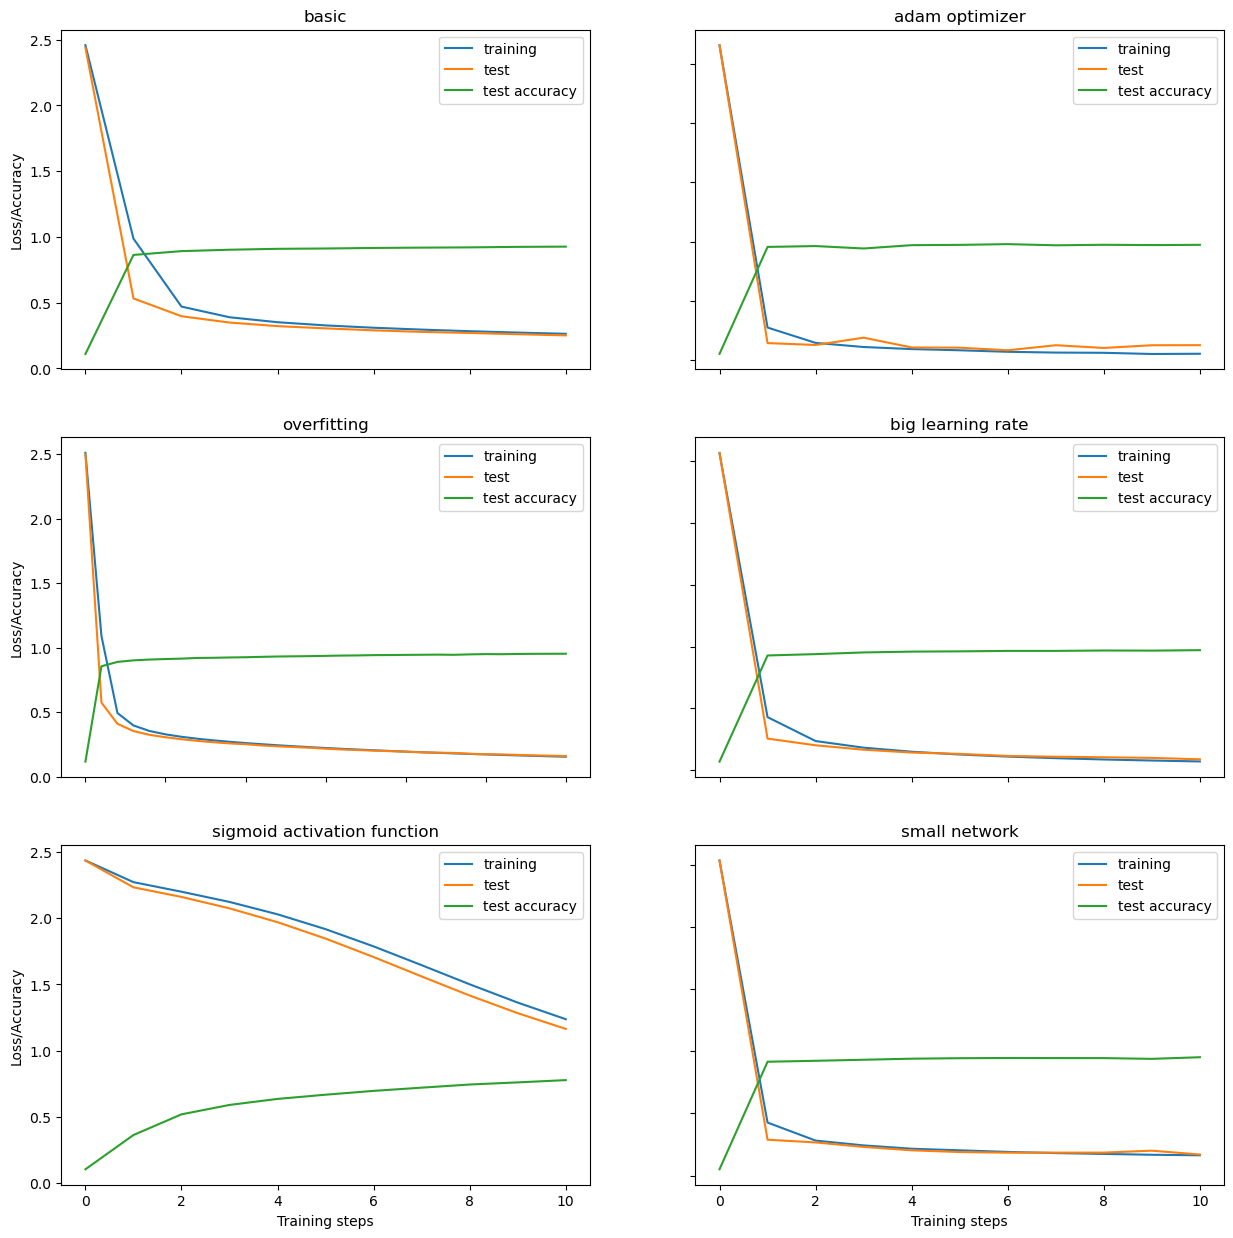

In [23]:
# plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for ax, key in zip(axs.flat, plotting.keys()):
    
    train_losses, test_losses, test_accuracies = plotting[key]
    
    line1, = ax.plot(train_losses)
    line2, = ax.plot(test_losses)
    line3, = ax.plot(test_accuracies)
    ax.legend((line1,line2, line3),("training","test", "test accuracy"))
    ax.set_title(key)
    ax.set(xlabel="Training steps", ylabel="Loss/Accuracy")
    ax.label_outer()
    
plt.show()